# 🐦 BIRD RECOGNITION

In [13]:
import tensorflow as tf
from tensorflow.keras.preprocessing import image_dataset_from_directory
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.layers import BatchNormalization, Dropout
import matplotlib.pyplot as plt

In [ ]:
# 1. Charger les données
dataset_path = "images"  # Remplace par le chemin de ton dataset

# 80% entraînement, 20% test
train_ds = image_dataset_from_directory(
    dataset_path,
    validation_split=0.2,
    subset="training",
    seed=123,
    image_size=(224, 224),
    batch_size=32
)

val_ds = image_dataset_from_directory(
    dataset_path,
    validation_split=0.2,
    subset="validation",
    seed=123,
    image_size=(224, 224),
    batch_size=32
)

# Prétraitement
AUTOTUNE = tf.data.AUTOTUNE
train_ds = train_ds.prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.prefetch(buffer_size=AUTOTUNE)


Found 3422 files belonging to 20 classes.
Using 2738 files for training.
Found 3422 files belonging to 20 classes.
Using 684 files for validation.


In [16]:

# 2. Importer un modèle pré-entraîné (MobileNetV2)
base_model = MobileNetV2(input_shape=(224, 224, 3), include_top=False, weights='imagenet')
# Fine-tuning : déverrouiller les dernières 2 couches
base_model.trainable = True

# On freeze toutes les couches sauf les 2 dernières
for layer in base_model.layers[:-2]:
    layer.trainable = False


In [17]:
# 3. Ajouter des couches pour la classification
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = BatchNormalization()(x)
x = Dense(128, activation='relu')(x)
x = Dropout(0.2)(x)  # 20% des neurones désactivés pendant l'entraînement
x = BatchNormalization()(x)
predictions = Dense(20, activation='softmax')(x)


model = Model(inputs=base_model.input, outputs=predictions)


In [18]:

# 4. Compiler le modèle
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

In [19]:
# 5. Entraîner le modèle
history = model.fit(train_ds, validation_data=val_ds, epochs=10, callbacks=[
    EarlyStopping(patience=3, restore_best_weights=True)
])

Epoch 1/10
86/86 ━━━━━━━━━━━━━━━━━━━━ 116s 1s/step - accuracy: 0.1989 - loss: 2.8769 - val_accuracy: 0.2822 - val_loss: 2.3778
Epoch 2/10
86/86 ━━━━━━━━━━━━━━━━━━━━ 169s 2s/step - accuracy: 0.5482 - loss: 1.5293 - val_accuracy: 0.3436 - val_loss: 2.2662
Epoch 3/10
86/86 ━━━━━━━━━━━━━━━━━━━━ 106s 1s/step - accuracy: 0.6551 - loss: 1.1864 - val_accuracy: 0.3743 - val_loss: 2.2621
Epoch 4/10
86/86 ━━━━━━━━━━━━━━━━━━━━ 171s 2s/step - accuracy: 0.7235 - loss: 0.9404 - val_accuracy: 0.3640 - val_loss: 2.2224
Epoch 5/10
86/86 ━━━━━━━━━━━━━━━━━━━━ 122s 1s/step - accuracy: 0.7764 - loss: 0.7612 - val_accuracy: 0.3743 - val_loss: 2.3193
Epoch 6/10
86/86 ━━━━━━━━━━━━━━━━━━━━ 154s 1s/step - accuracy: 0.8359 - loss: 0.5984 - val_accuracy: 0.3889 - val_loss: 2.2007
Epoch 7/10
86/86 ━━━━━━━━━━━━━━━━━━━━ 119s 1s/step - accuracy: 0.8788 - loss: 0.4746 - val_accuracy: 0.4240 - val_loss: 2.0963
Epoch 8/10
86/86 ━━━━━━━━━━━━━━━━━━━━ 146s 1s/step - accuracy: 0.9193 - loss: 0.3600 - val_accuracy: 0.4211 - v

In [20]:

# 6. Évaluer les performances
loss, accuracy = model.evaluate(val_ds)
print(f"Accuracy : {accuracy*100:.2f}%")

22/22 ━━━━━━━━━━━━━━━━━━━━ 35s 2s/step - accuracy: 0.4702 - loss: 1.9625
Accuracy : 45.18%


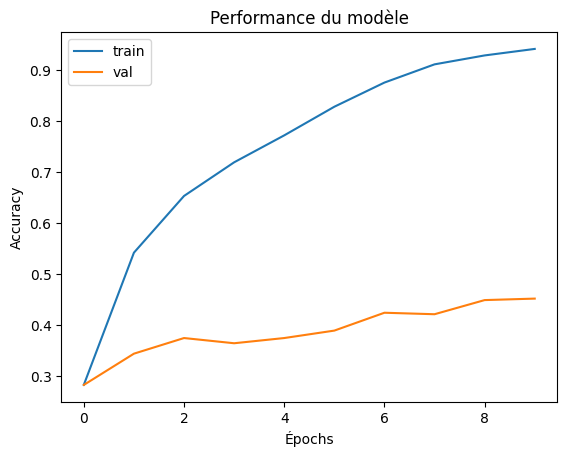

In [21]:

# 7. Afficher l’évolution de l’apprentissage
plt.plot(history.history['accuracy'], label='train')
plt.plot(history.history['val_accuracy'], label='val')
plt.xlabel('Épochs')
plt.ylabel('Accuracy')
plt.legend()
plt.title("Performance du modèle")
plt.show()